In [1]:
import cv2 as cv2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from update_DB import Update_DB
from query import Thumbnails

In [2]:
udb = Update_DB()
udb.loadImages()
udb.calculateMean()
udb.preprocess_data()
fm = udb.get_features('fc8')
print(fm.shape)

(106, 1000)


106
5565
11130


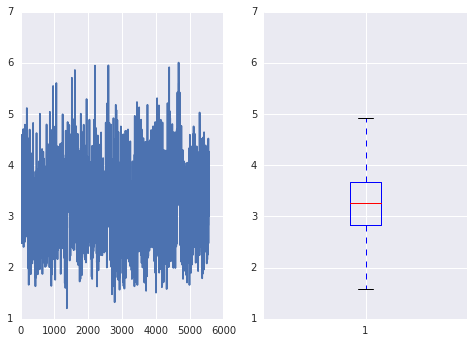

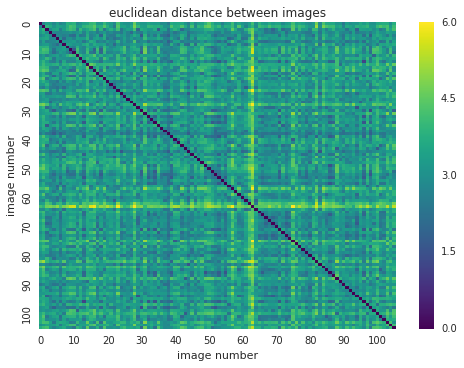

In [12]:
import itertools
import seaborn as sns

num_img = fm.shape[0]
print(num_img)
# number of possible combinations 
num_comb = (num_img)*(num_img-1)/2
num_perm = (num_img)*(num_img-1)
print(num_comb)
print(num_perm)

def _calc_rmse(fm1, fm2):
    return np.sqrt(np.mean((fm1-fm2)**2))

vect_comb = np.zeros([num_comb,3])
comb_matrix = np.zeros([num_img,num_img])
for i, comb in enumerate(itertools.combinations(np.arange(num_img), 2)):
    vect_comb[i,0:2] = np.array(comb)
    rmse   = _calc_rmse(fm[comb[0],:],fm[comb[1],:])
    vect_comb[i,2]   = rmse
    comb_matrix[comb[0],comb[1]] = rmse
    comb_matrix[comb[1],comb[0]] = rmse

vect_perm = np.zeros([num_perm,3])
for i, perm in enumerate(itertools.permutations(np.arange(num_img), 2)):
    vect_perm[i,0:2] = np.array(perm)
    vect_perm[i,2]   = _calc_rmse(fm[perm[0],:],fm[perm[1],:])

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(vect_comb[:,2][:])
ax2.boxplot(vect_comb[:,2][:])
plt.show()

comb_df = pd.DataFrame(comb_matrix)

fm_plot = sns.heatmap(comb_matrix,  xticklabels = 10, yticklabels = 10, cmap = 'viridis')
fm_plot.set(xlabel='image number', ylabel='image number', title = 'euclidean distance between images')
fig = fm_plot.get_figure()
fig.savefig('feature_map_plot.png')


In [13]:
# get similar combinations list
std_fm = np.std(vect_comb[:,2])
mean_fm = np.mean(vect_comb[:,2])
print('MEAN: %.2f, STD: %.2f' % (mean_fm, std_fm))

fm_df = pd.DataFrame(vect_comb[:,:])
fm_df.dtypes
fm_df[[0,1]] = fm_df[[0,1]].astype(int)
threshold = (mean_fm-2.5*std_fm)
threshold = 1.7
comb_similar = fm_df.loc[fm_df[2] <  threshold]
comb_similar.shape
comb_similar
# np.unique(comb_similar[0:2])

MEAN: 3.27, STD: 0.64


,0,1,2
241,2,35,1.665248
439,4,30,1.637288
909,9,10,1.642765
1307,13,34,1.696722
1326,13,53,1.603264
1344,13,71,1.677071
1369,13,96,1.206015
2263,24,44,1.632151
2703,29,94,1.479858
2755,30,71,1.636337


In [14]:
mean_fm-2.5*std_fm

1.6714290262746065

In [15]:
# get similar permutations list
fm_df = pd.DataFrame(vect_perm[:,:])
fm_df.dtypes
fm_df[[0,1]] = fm_df[[0,1]].astype(int)

perm_similar = fm_df.loc[fm_df[2] <  threshold]
perm_similar.shape
perm_similar
# np.unique(comb_similar[0:2])

,0,1,2
244,2,35,1.665248
449,4,30,1.637288
954,9,10,1.642765
1059,10,9,1.642765
1398,13,34,1.696722
1417,13,53,1.603264
1435,13,71,1.677071
1460,13,96,1.206015
2563,24,44,1.632151
3138,29,94,1.479858


<class 'pandas.core.frame.DataFrame'>


24

In [20]:
# plt.imshow(udb.images[0])
# plt.imshow(udb.images[1][0])
def get_filename_lst(similar_df):
    unique_original_lst = similar_df[0].unique()
    filenames_lst = []
    
    for unique_idx in unique_original_lst:      
        # similar indexes
        original_idx = unique_idx
#         print(original_idx)
        similar_idxs = [int(i) for i in similar_df[similar_df[0] == unique_idx].values[:, 1] ]
#         print(similar_idxs)
        # similar filenames
        similar_fnms_lst = [udb.img_filenames[original_idx]]
        similar_fnms_lst.extend([udb.img_filenames[idx] for idx in similar_idxs] )
#         print(similar_fnms_lst)

        filenames_lst.append(similar_fnms_lst)
    
    return filenames_lst

In [9]:
print(get_filename_lst(perm_similar))


[['IMG_332679765605679.jpeg', 'Screenshot_2016-07-20-11-26-51-1.png'], ['20160720_075849-1.jpg', 'IMG_9776.jpg'], ['Screenshot_2016-07-20-11-27-30-1.png', 'IMG_20160601_143735105.jpg', 'IMG_20160527_153932696.jpg'], ['IMG_9978070570836.jpeg', 'Screenshot_2016-07-20-11-26-06-1.png'], ['IMG_20160705_221052.jpg', '2015-02-27 15.42.59.jpg'], ['IMG_20141130_105816501_HDR.jpg', 'IMG_20151017_095054058_HDR.jpg'], ['2015-09-21 22.11.09.jpg', 'IMG_20150722_184142.jpg'], ['Screenshot_2016-07-20-11-25-10-1.png', '20160718_202645.jpg'], ['47513286cde53d34a320eb94a99389ff.jpg', 'IMG_20160629_152357.jpg'], ['Izumi Miyazaki 9.jpg', '2015-03-07 18.50.44.jpg'], ['Screenshot_2016-07-20-11-26-06-1.png', 'IMG_9978070570836.jpeg', 'IMG_1403.JPG'], ['2016-07-08 20.22.19.jpg', '2016-07-09 15.47.34.jpg'], ['IMG_20160601_143735105.jpg', 'Screenshot_2016-07-20-11-27-30-1.png', 'IMG_20160527_153932696.jpg'], ['IMG_20160527_153932696.jpg', 'Screenshot_2016-07-20-11-27-30-1.png', 'IMG_20160601_143735105.jpg'], ['3

In [21]:
prev_fnm_lst = get_filename_lst(perm_similar)

for img_lst in prev_fnm_lst:
    prev = Thumbnails(227, 2, 5)
    prev.create_preview( img_lst )
    prev.save_to_file('similar_to_' + img_lst[0] + '.png')